# [Theoretical Analysis of Efficiency and Robustness of Softmax and Gap-Increasing Operators in Reinforcement Learning](https://proceedings.mlr.press/v89/kozuno19a.html)

今回はこの論文中に書かれているConservative Value Iteration(CVI)について書いていきたいと思います．

CVIには $\alpha,\beta$ のパラメータがあり, そのパラメータによって, Soft Value Iteration(SVI)やDynamic Plicy Programming(DPP)になり，この関係性から,理論的な解析もできるといことと実装上も楽に行えます．

---

下にCVIの更新時に使う作用素とそれに伴ったベルマン最適作用素を示します．


$$\left(\boldsymbol{m}_\beta Q\right)(s):=\frac{1}{\beta} \log \left(\frac{1}{|\mathcal{A}|} \sum_{a \in \mathcal{A}} \exp (\beta Q(s, a))\right)$$

$$
\boldsymbol{T}_B: Q \in \mathcal{Q} \mapsto r+\gamma \boldsymbol{Pm}_\beta Q \in \mathcal{Q}
$$

上の式はmellowmax作用素とベルマン最適作用素です．

---


次にCVIの更新式を示します．

$$
\begin{gathered}
\Psi_{k+1}=\boldsymbol{T}_\beta \Psi_k+\alpha\left(\Psi_k-\boldsymbol{m}_\beta \Psi_k\right), \\

\pi_{k+1}(a \mid s)=\frac{\exp \left(\beta \Psi_{k+1}(s, a)\right)}{\sum_{b \in \mathcal{A}} \exp \left(\beta \Psi_{k+1}(s, b)\right)}
\end{gathered}
$$

$\alpha \in [0,1] , \beta \in (0,\infty) \cup{\infty}$

ここで, $\tau,\sigma$ をKL距離による罰則, エントロピーによるボーナスのパラメータとして考えます．

上のCVIの更新式で書かれた $\alpha$ と $\beta$ の関係性とCVIから他のアルゴリズムへの変換を説明します．

1. KL距離による罰則を考えないとき ($\tau = 0$), $\alpha=0,\beta = \sigma$ なら CVIはSVIになる．
2. エントロピーによるボーナスを考えないとき ($\sigma = 0$), $\alpha = 1, \beta = \tau$ ならCVIはDPPになる．

---

そして,上記の例以外での $\alpha,\beta$ と $\tau,\sigma$ の関係性は次のようにかける．
$$
\alpha:=\frac{\tau} {(\tau+\sigma)}, \beta:=\frac{1}{(\tau+\sigma)}
$$

早速, コードを書いていきます．


In [2]:
import numpy as np
from typing import NamedTuple

S = 5 #state_size
A = 3  #action_size
S_array = np.arange(S) #state_set
A_array = np.arange(A) #action_set
gamma = 0.99 

rew = np.random.rand(S,A) * 10 #報酬

P = np.random.rand(S*A, S) #遷移確率
P = P / np.sum(P,axis=-1,keepdims=True)
P = P.reshape(S,A,S)
np.testing.assert_almost_equal(P.sum(axis=-1),1) #確率1になっているか確認

# MDPの定義

class MDP(NamedTuple):
    S_array : np.array
    A_array : np.array
    gamma : float
    rew : np.array
    P : np.array

    @property
    def S(self) -> int:
        return len(self.S_array)

    @property
    def A(self) -> int:
        return len(self.A_array)

mdp = MDP(S_array,A_array,gamma,rew,P)
print(mdp.rew.shape)
print(mdp.P.shape)

(5, 3)
(5, 3, 5)


In [3]:
import jax
import jax.numpy as jnp
@jax.jit
def mellowmax_operator(beta:float, action_size:int,q:jnp.ndarray):

    return jnp.log(jnp.sum(jnp.exp(beta*q -(beta*q).max()),axis=-1)/ action_size) / beta + (beta * q).max() / beta

@jax.jit
def get_policy(q:jnp.ndarray, beta:float):
    max_q = (beta * q).max()
    return jnp.exp(beta*q - max_q)/ jnp.sum(jnp.exp(beta*q - max_q),axis=-1)


In [4]:
from functools import partial

@partial(jax.jit,static_argnames=('tau','sigma'))
def Bellman_operator(mdp:MDP, q:jnp.array,tau:float,sigma:float):
    S,A = mdp.S,mdp.A
    assert q.shape == (S,A)
    # no KL penalty
    if tau == 0.0:
        alpha = 0.0
        beta = sigma

    # no entropy bonus    
    elif sigma == 0.0:
        alpha = 1.0
        beta = tau
        
    else:
        alpha = tau / (tau + sigma)
        beta = 1 / (tau + sigma)

    mb_q = mellowmax_operator(beta,A,q)
    
    T_b = mdp.rew + mdp.gamma * mdp.P @ mb_q
    
    hard_gap = alpha * (q - jnp.expand_dims(mb_q,axis=1))

    assert T_b.shape == (S,A)
    assert hard_gap.shape == (S,A)

    return T_b + hard_gap

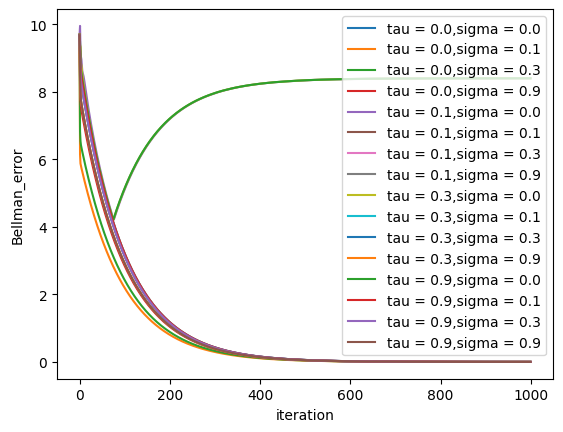

In [7]:
import matplotlib.pyplot as plt
key = jax.random.PRNGKey(0)

S,A = mdp.S, mdp.A

# pi = jax.random.uniform(key=key,shape=(S,A))
# pi = pi / jnp.sum(pi,axis=1,keepdims=True)

taus = [0.0,0.1,0.3,0.9,]
sigmas = [0.0,0.1,0.3,0.9,]


for tau in taus:
    for sigma in sigmas:
        
        q_before = jax.random.uniform(key = key,shape = (S,A))
        errors = []
        

        for i in range(1000):
            q_after = Bellman_operator(mdp,q_before,tau=tau,sigma=sigma)
            errors.append(np.abs(q_after - q_before).max())
            q_before = q_after
        
        plt.plot(errors,label=f'tau = {tau},sigma = {sigma}')

plt.ylabel('Bellman_error')
plt.xlabel('iteration')
plt.legend()